In [1]:
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Text preprocessing function
str_punc = string.punctuation.replace(',', '').replace("'",'')

def clean(text):
    global str_punc
    text = re.sub(r'[^a-zA-Z ]', '', text)
    text = text.lower()
    return text    

In [4]:
# Read dataset & Preprocess text
df_train = pd.read_csv('/content/drive/MyDrive/PROA/ML/Assignment/train.txt', names=['Text', 'Emotion'], sep=';')
df_val = pd.read_csv('/content/drive/MyDrive/PROA/ML/Assignment/val.txt', names=['Text', 'Emotion'], sep=';')
df_test = pd.read_csv('/content/drive/MyDrive/PROA/ML/Assignment/train.txt', names=['Text', 'Emotion'], sep=';')

X_train = df_train['Text'].apply(clean)
y_train = df_train['Emotion']

X_test = df_test['Text'].apply(clean)
y_test = df_test['Emotion']

X_val = df_val['Text'].apply(clean)
y_val = df_val['Emotion']

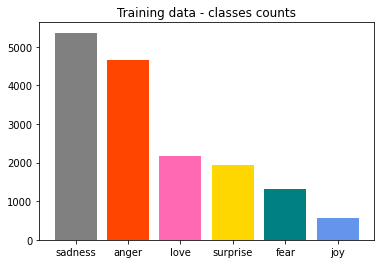

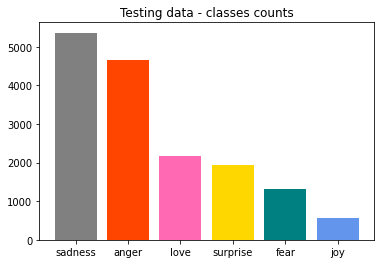

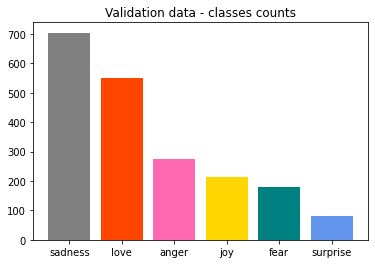

In [5]:
# Visualize classes counts
colors = np.array(["gray", 'orangered', 'hotpink', 'gold', 'teal', 'cornflowerblue'])

plt.bar(y_train.unique(), y_train.value_counts(), color = colors)
plt.title("Training data - classes counts")
plt.show()

plt.bar(y_test.unique(), y_test.value_counts(), color = colors)
plt.title("Testing data - classes counts")
plt.show()

plt.bar(y_val.unique(), y_val.value_counts(), color = colors)
plt.title("Validation data - classes counts")
plt.show()

In [6]:
# Encode labels
# Sudah disediakan beberapa variable, lengkapi variabel tersebut
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [7]:
# Tokenize words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(pd.concat([X_train, X_test], axis=0))

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)

X_train = pad_sequences(sequences_train, maxlen=256, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=256, truncating='pre')
X_val = pad_sequences(sequences_val, maxlen=256, truncating='pre')

vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary size = {vocabSize}")

Vocabulary size = 15213


In [8]:
#Read GloVE embeddings
path_to_glove_file = '/content/drive/MyDrive/PROA/ML/Assignment/glove.6B.200d.txt'
num_tokens = vocabSize
embedding_dim = 200
hits = 0
misses = 0
embeddings_index = {}

# Read word vectors
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print("Found %s word vectors." % len(embeddings_index))


# Assign word vectors to our dictionary/vocabulary
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Found 400000 word vectors.
Converted 14212 words (1000 misses)


In [23]:
# Define 
# Embedding
embedding_size = 200

# Build neural network architecture
model = Sequential([
    Embedding(vocabSize, embedding_size, input_length=X_train.shape[1]),
    Bidirectional(LSTM(128, return_sequences=True)),
    Bidirectional(LSTM(256)),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(6, activation='softmax')
])

# Model History
print(model.summary())



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 256, 200)          3042600   
                                                                 
 bidirectional_10 (Bidirecti  (None, 256, 256)         336896    
 onal)                                                           
                                                                 
 bidirectional_11 (Bidirecti  (None, 512)              1050624   
 onal)                                                           
                                                                 
 dense_14 (Dense)            (None, 256)               131328    
                                                                 
 dense_15 (Dense)            (None, 128)               32896     
                                                                 
 dense_16 (Dense)            (None, 64)               

In [24]:
adam = Adam(learning_rate=0.005)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [25]:
#Callback
callback = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
)

In [26]:
# Fit model
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    batch_size=256,
                    epochs=30,
                    callbacks=[callback]
                   )

Epoch 1/30
63/63 [==============================] - 21s 233ms/step - loss: 1.4131 - accuracy: 0.4639 - val_loss: 1.0337 - val_accuracy: 0.6190
Epoch 2/30
63/63 [==============================] - 13s 212ms/step - loss: 0.6279 - accuracy: 0.7837 - val_loss: 0.4117 - val_accuracy: 0.8585
Epoch 3/30
63/63 [==============================] - 13s 213ms/step - loss: 0.2676 - accuracy: 0.9041 - val_loss: 0.2816 - val_accuracy: 0.9070
Epoch 4/30
63/63 [==============================] - 14s 219ms/step - loss: 0.1326 - accuracy: 0.9475 - val_loss: 0.2543 - val_accuracy: 0.9195
Epoch 5/30
63/63 [==============================] - 14s 217ms/step - loss: 0.0911 - accuracy: 0.9638 - val_loss: 0.2406 - val_accuracy: 0.9160
Epoch 6/30
63/63 [==============================] - 14s 217ms/step - loss: 0.0636 - accuracy: 0.9759 - val_loss: 0.2357 - val_accuracy: 0.9215
Epoch 7/30
63/63 [==============================] - 14s 218ms/step - loss: 0.0473 - accuracy: 0.9815 - val_loss: 0.2872 - val_accuracy: 0.9165

In [27]:
model.evaluate(X_val, y_val, verbose=1)

63/63 [==============================] - 2s 27ms/step - loss: 0.2337 - accuracy: 0.9295


[0.23374029994010925, 0.9294999837875366]

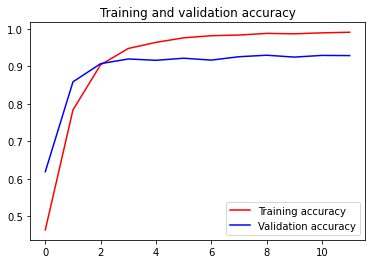

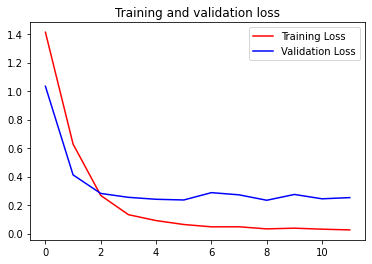

In [28]:
# Visualize Loss & Accuracy

%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [31]:
# Classify custom sample

sentences = ["I think this lovely watch is very expensive",
             "I’m not in a good mood.",
             "This is the lowest time in my life."]
for sentence in sentences:
    print(sentence)
    sentence = clean(sentence)
    sentence = tokenizer.texts_to_sequences([sentence])
    sentence = pad_sequences(sentence, maxlen=256, truncating='pre')
    result = le.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
    proba =  np.max(model.predict(sentence))
    print(f"{result} : {proba}\n")

I think this lovely watch is very expensive
love : 0.8793091177940369

I’m not in a good mood.
joy : 0.9616058468818665

This is the lowest time in my life.
sadness : 0.5370383858680725



In [32]:
import pickle
with open('tokenizer.pickle', 'wb') as f:
    pickle.dump(tokenizer, f)
    
with open('labelEncoder.pickle', 'wb') as f:
    pickle.dump(le, f)
    
    
model.save('Emotion Recognition.h5')